# Modeling

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import timedelta

#### Import data

In [2]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\flagship'

In [3]:
toy_dataset_df = pd.read_csv('toy_dataset_1_10_23.csv')
toy_products_df = pd.read_csv('toy_products_1_10_23.csv')

print(toy_products_df.shape)
print(toy_dataset_df.shape)

(3125, 6)
(32151, 23)


#### Clean data

In [4]:
toy_dataset_df['timestamp'] = pd.to_datetime(toy_dataset_df['timestamp'])

In [5]:
# Filter to only 'Online Store'
toy_dataset_df = toy_dataset_df[toy_dataset_df['point_of_sales']=='Online Store']

In [6]:
toy_dataset_df.shape

(29338, 23)

In [7]:
# Add column for transaction number for each user
df_sorted = toy_dataset_df.sort_values('timestamp').groupby(['hash_customer', 'timestamp']).first().reset_index()
df_sorted['transaction_num'] = df_sorted.groupby('hash_customer', sort=False)['timestamp'].rank(method='dense')
# Merge the transaction number back into the original dataframe
toy_dataset_df = toy_dataset_df.merge(df_sorted[['hash_customer', 'timestamp', 'transaction_num']], 
                                      on=['hash_customer', 'timestamp'])

#### Create train, test data sets based on date split

In [8]:
# create title-gender field
toy_dataset_df.loc[:,'product_title_gender'] = toy_dataset_df['product_title'] + '-' + toy_dataset_df['product_gender']

In [9]:
split_date = '2022-04-01' # choose a date to split the data - roughly 80/20 split
train = toy_dataset_df[toy_dataset_df['timestamp'] < split_date]
test = toy_dataset_df[toy_dataset_df['timestamp'] >= split_date]

In [10]:
test_dates = test['timestamp'].dt.date.unique().tolist()
print(len(test_dates))
train_dates = train['timestamp'].dt.date.unique().tolist()
print(len(train_dates))

230
894


In [11]:
# percent of data in training data set
round(train.shape[0] / toy_dataset_df.shape[0] * 100.0,2)

81.98

In [12]:
print(train.shape)
print(test.shape)

(24050, 25)
(5288, 25)


### Baseline Model - top 10 titles over previous week

In [13]:
def get_top10_title_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular product_titles sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby('product_title').size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['transaction_date'] = as_of_dt
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'prev_wk_cnt', 'transaction_date', 'pred_rank']
    return top10_last_wk_df

In [14]:
get_top10_title_preds(as_of_dt='2021-08-13')

,title_pred,prev_wk_cnt,transaction_date,pred_rank
4,Olympic Running,64,2021-08-13,1.0
2,Iron Running,31,2021-08-13,2.0
8,Vanguard Sandal,12,2021-08-13,3.0
0,Classic Sneaker,9,2021-08-13,4.0
1,Hustler Boot,9,2021-08-13,5.0
3,League Running,8,2021-08-13,6.0
5,Rogue Sneaker,8,2021-08-13,7.0
6,Scalar Sandal,4,2021-08-13,8.0
7,Stacked Hiking Boot,2,2021-08-13,9.0


In [15]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred','pred_rank']], 
                       left_on='product_title',
                       right_on='title_pred',
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,

In [16]:
assert full_eval_df.shape[0] == test.shape[0]

In [17]:
def print_eval_metrics(eval_df):
    pct_purchases_top10 = round(eval_df['pred_rank'].count() / eval_df.shape[0],2) * 100.0
    avg_rank = round(eval_df['pred_rank'].mean(),2)
    reciprocal_ranks = 1 / eval_df['pred_rank']
    mrr = round(np.mean(reciprocal_ranks),3)
    print(f'Percent of purchases ranked in top 10: {pct_purchases_top10}%')
    print(f'Average rank of purchases: {avg_rank}')
    print(f'Mean Reciprocal Rank: {mrr}')

In [18]:
print_eval_metrics(eval_df=full_eval_df)

Percent of purchases ranked in top 10: 95.0%
Average rank of purchases: 3.73
Mean Reciprocal Rank: 0.49


In [19]:
def print_category_eval_metrics(eval_df, category_var):
    categories = eval_df[category_var].unique()
    for category in categories:
        df_category = eval_df[eval_df[category_var] == category]
        print(f'{category} purchases: {df_category.shape[0]}')
        pct_purchases_top10 = round(df_category['pred_rank'].count() / df_category.shape[0],2) * 100.0
        print(f'{category} purchases ranked in top 10: {pct_purchases_top10}%')
        avg_rank = round(df_category['pred_rank'].mean(),2)
        print(f'{category} avg rank of purchases: {avg_rank}')
        reciprocal_ranks = 1 / df_category['pred_rank']
        mrr = np.mean(reciprocal_ranks)
        print(f"{category} MRR: {mrr:.3f}")
        print('')

In [20]:
print_category_eval_metrics(eval_df=full_eval_df, 
                            category_var = 'product_category')

Running purchases: 3119
Running purchases ranked in top 10: 100.0%
Running avg rank of purchases: 2.39
Running MRR: 0.657

Boot purchases: 976
Boot purchases ranked in top 10: 90.0%
Boot avg rank of purchases: 4.73
Boot MRR: 0.283

Sneaker purchases: 586
Sneaker purchases ranked in top 10: 92.0%
Sneaker avg rank of purchases: 6.89
Sneaker MRR: 0.167

Sandal purchases: 607
Sandal purchases ranked in top 10: 84.0%
Sandal avg rank of purchases: 6.8
Sandal MRR: 0.171



In [21]:
print_category_eval_metrics(eval_df=full_eval_df, 
                            category_var = 'product_gender')

Kids purchases: 241
Kids purchases ranked in top 10: 100.0%
Kids avg rank of purchases: 1.02
Kids MRR: 0.992

Men purchases: 1481
Men purchases ranked in top 10: 96.0%
Men avg rank of purchases: 4.32
Men MRR: 0.369

Women purchases: 3247
Women purchases ranked in top 10: 97.0%
Women avg rank of purchases: 3.82
Women MRR: 0.478

Unisex purchases: 130
Unisex purchases ranked in top 10: 38.0%
Unisex avg rank of purchases: 4.56
Unisex MRR: 0.334

Youth purchases: 189
Youth purchases ranked in top 10: 100.0%
Youth avg rank of purchases: 1.02
Youth MRR: 0.989



### Baseline model - top 10 title-gender products over previous week

In [22]:
def get_top10_title_gender_preds(as_of_dt, prev_days=7, top_n=10):
    """
    Function to return the top 10 most popular title-gender products sold in previous n days from as_of date
    Returns a pandas dataframe of 10 records
    """
    given_date = pd.to_datetime(as_of_dt)
    start_date = given_date - timedelta(days=prev_days)
    last_week_df = toy_dataset_df[(toy_dataset_df['timestamp']<given_date) & 
                                  (toy_dataset_df['timestamp']>start_date)]
    top10_last_wk_df = last_week_df.groupby(['product_title', 'product_gender']).size().reset_index(name='count').sort_values('count', ascending=False).head(top_n)
    top10_last_wk_df['title_rank'] = top10_last_wk_df['count'].rank(method='first', ascending=False)
    top10_last_wk_df.columns = ['title_pred', 'gender_pred', 'prev_wk_cnt', 'pred_rank']
    top10_last_wk_df['transaction_date'] = as_of_dt
    return top10_last_wk_df

In [23]:
get_top10_title_gender_preds(as_of_dt = '2022-08-13', prev_days=7, top_n=10)

,title_pred,gender_pred,prev_wk_cnt,pred_rank,transaction_date
13,Olympic Running,Women,26,1.0,2022-08-13
8,League Running,Women,16,2.0,2022-08-13
0,Bejeweled Boot,Unisex,15,3.0,2022-08-13
6,Iron Running,Women,15,4.0,2022-08-13
4,Hustler Boot,Women,12,5.0,2022-08-13
14,Olympic Running,Youth,8,6.0,2022-08-13
10,Marathon Running,Women,8,7.0,2022-08-13
21,Stacked Hiking Boot,Women,7,8.0,2022-08-13
17,Rogue Sneaker,Women,7,9.0,2022-08-13
5,Iron Running,Men,7,10.0,2022-08-13


In [24]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates):
    print(index, end=',')
    
    pred_df = get_top10_title_gender_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred', 'gender_pred', 'pred_rank']], 
                       left_on=['product_title','product_gender'],
                       right_on=['title_pred', 'gender_pred'],
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,

In [25]:
assert full_eval_df.shape[0] == test.shape[0]

In [26]:
print_eval_metrics(eval_df=full_eval_df)

Percent of purchases ranked in top 10: 63.0%
Average rank of purchases: 4.21
Mean Reciprocal Rank: 0.449


<AxesSubplot:>

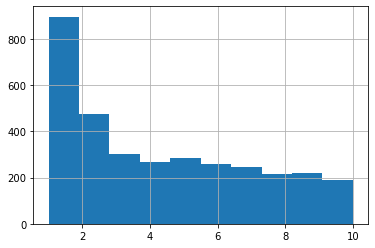

In [27]:
full_eval_df['pred_rank'].hist()

In [28]:
print_category_eval_metrics(eval_df=full_eval_df, 
                            category_var = 'product_category')

Running purchases: 3119
Running purchases ranked in top 10: 78.0%
Running avg rank of purchases: 3.89
Running MRR: 0.500

Boot purchases: 976
Boot purchases ranked in top 10: 59.0%
Boot avg rank of purchases: 3.96
Boot MRR: 0.392

Sneaker purchases: 586
Sneaker purchases ranked in top 10: 26.0%
Sneaker avg rank of purchases: 7.31
Sneaker MRR: 0.176

Sandal purchases: 607
Sandal purchases ranked in top 10: 31.0%
Sandal avg rank of purchases: 6.53
Sandal MRR: 0.179



In [29]:
print_category_eval_metrics(eval_df=full_eval_df, 
                            category_var = 'product_gender')

Kids purchases: 241
Kids purchases ranked in top 10: 59.0%
Kids avg rank of purchases: 6.25
Kids MRR: 0.203

Men purchases: 1481
Men purchases ranked in top 10: 42.0%
Men avg rank of purchases: 6.46
Men MRR: 0.205

Women purchases: 3247
Women purchases ranked in top 10: 76.0%
Women avg rank of purchases: 3.49
Women MRR: 0.528

Unisex purchases: 130
Unisex purchases ranked in top 10: 28.999999999999996%
Unisex avg rank of purchases: 2.21
Unisex MRR: 0.761

Youth purchases: 189
Youth purchases ranked in top 10: 42.0%
Youth avg rank of purchases: 6.54
Youth MRR: 0.184



### Collaborative Filtering

In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic
from surprise.model_selection import train_test_split

In [ ]:
# Define the Reader object
reader = Reader(rating_scale=(0, 1))

In [ ]:
cf_train_data_set = train.groupby(['hash_customer', 'product_title_gender']).size().reset_index(name='count')

In [ ]:
cf_train_data_set.head()

In [ ]:
# Load the data into the Surprise dataset format
data = Dataset.load_from_df(cf_train_data_set, reader)

In [ ]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2)

In [ ]:
# Define the algorithm
sim_options = {"name": "cosine", "user_based": False}
algo = KNNBasic(sim_options=sim_options)

In [ ]:
# Train the model on the training set
algo.fit(trainset)

In [ ]:
# Test the model on the test set
predictions = algo.test(testset)

In [ ]:
# Create a dictionary of items for each user
from collections import defaultdict
user_items = defaultdict(list)
for uid, iid, true_rating, est_rating, _ in predictions:
    user_items[uid].append((iid, est_rating))

# Sort the items for each user by their estimated rating
for uid, items in user_items.items():
    items.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 item recommendations for each user
top_n = {}
for uid, items in user_items.items():
    top_n[uid] = [iid for (iid, _) in items[:10]]

In [ ]:
top_n

In [ ]:
from surprise import SVD

In [ ]:
# Define the algorithm
algo = SVD(verbose=True, n_epochs=10)

# Train the model on the training set
algo.fit(trainset)

# Test the model on the test set
predictions = algo.test(testset)

In [ ]:
# from surprise.model_selection import cross_validate

In [ ]:
# cross_validate(algo, trainset, measures=['RMSE', 'MAE'], cv=3, verbose=True)

In [ ]:
# Create a dictionary of items for each user
from collections import defaultdict
user_items = defaultdict(list)
for uid, iid, true_rating, est_rating, _ in predictions:
    user_items[uid].append((iid, est_rating))

# Sort the items for each user by their estimated rating
for uid, items in user_items.items():
    items.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 item recommendations for each user
top_n = {}
for uid, items in user_items.items():
    top_n[uid] = [iid for (iid, _) in items[:10]]

In [ ]:
top_n

## Binary classifier

#### Create training data set

In [30]:
positive_samples = train[['timestamp', 'transaction_id', 'hash_customer', 
                          'sale_amount', 'product_title', 'product_color', 'product_gender',
                          'product_category', 'referrer_source', 'product_title_gender']].copy()

positive_samples.loc[:,'purchase'] = 1

In [31]:
positive_samples.head()

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,product_title_gender,purchase
0,2019-10-17 17:00:00,13964574791861793493,118171218419602151,141.0,Rogue Sneaker,Midnight Green (Eagle Green),Women,Sneaker,Direct,Rogue Sneaker-Women,1
1,2022-03-26 04:00:00,15462755904385104185,118171218419602151,262.0,Vanguard Sandal,Prussian Blue,Women,Sandal,Direct,Vanguard Sandal-Women,1
2,2019-10-18 06:00:00,5418521222138237582,15372924648196696535,141.0,Rogue Sneaker,Electric Purple,Women,Sneaker,Direct,Rogue Sneaker-Women,1
3,2021-10-03 19:00:00,13807911046559617059,15372924648196696535,147.0,Classic Sneaker,Electric Purple,Women,Sneaker,Direct,Classic Sneaker-Women,1
4,2019-10-18 09:00:00,17285359619674932653,10040016928726048703,194.0,Olympic Running,Stormcloud,Women,Running,Search,Olympic Running-Women,1


In [32]:
genders = train['product_gender'].unique()
print(genders)

colors = train['product_color'].unique()
print(colors)

['Women' 'Men' 'Kids' 'Youth' 'Unisex']
['Midnight Green (Eagle Green)' 'Prussian Blue' 'Electric Purple'
 'Stormcloud' 'Vermilion (Plochere)' 'Topaz' 'Royal Blue (Web)'
 'Lavender Purple' 'Han Purple' 'Burnt Sienna' 'Green (Munsell)'
 'Dark Red' 'Electric Green' 'Fern Green' 'Ruby Red' 'Mikado Yellow'
 'Pastel Magenta' 'Canary Yellow' 'Dartmouth Green' 'Dark Powder Blue'
 'Alice Blue' 'Mordant Red 19' 'Sky Blue' 'Yellow-Green'
 'Selective Yellow']


In [33]:
def calc_user_features(as_of_dt):
    """
    Function to calculate user features
    Returns dataframe
    """
    hist_data = toy_dataset_df[(toy_dataset_df['timestamp'].dt.date < pd.to_datetime(as_of_dt))]

    agg_df = hist_data.groupby('hash_customer').agg({
        'product_title': ['count'],
        'transaction_id': ['nunique'],
        'sale_amount': ['sum', 'mean']
    }).reset_index()

    agg_df.columns = ['hash_customer', 'user_title_cnt', 
                      'user_trans_cnt', 'user_tot_sales', 'user_avg_prod_cost']
    return agg_df

In [34]:
calc_user_features(as_of_dt='2022-03-26').head()

,hash_customer,user_title_cnt,user_trans_cnt,user_tot_sales,user_avg_prod_cost
0,2785466729578054,3,2,594.0,198.000000
1,2943184540671871,6,4,1186.0,197.666667
2,4042200167694193,5,3,970.0,194.000000
3,6606248094173010,1,1,198.0,198.000000
4,11352255998594515,2,2,392.0,196.000000


In [35]:
def calc_title_features(as_of_dt):
    """
    Function to calculate features
    Returns dataframe
    """
    hist_data = toy_dataset_df[(toy_dataset_df['timestamp'].dt.date < pd.to_datetime(as_of_dt))]

    agg_df = hist_data.groupby('product_title').agg({
        'product_title': ['count'],
    }).reset_index()

    agg_df.columns = ['product_title', 'title_tot_sales']
    return agg_df

In [36]:
calc_title_features(as_of_dt='2022-03-26').head()

,product_title,title_tot_sales
0,Alley Boot,9
1,Classic Sneaker,1756
2,Corner Sandal,100
3,Evermore Boot,120
4,Gator Sandal,87


In [37]:
def calc_titgen_features(as_of_dt):
    """
    Function to calculate title-gender features
    Returns dataframe
    """
    hist_data = toy_dataset_df[(toy_dataset_df['timestamp'].dt.date < pd.to_datetime(as_of_dt))]

    agg_df = hist_data.groupby('product_title_gender').agg({
        'product_title': ['count'],
        'transaction_id': ['nunique'],
        'sale_amount': ['sum', 'mean']
    }).reset_index()

    agg_df.columns = ['product_title_gender', 'titgen_title_cnt',
                      'titgen_trans_cnt', 'titgen_tot_sales', 'titgen_avg_prod_cost']
    return agg_df

In [38]:
calc_titgen_features(as_of_dt='2022-03-26').head()

,product_title_gender,titgen_title_cnt,titgen_trans_cnt,titgen_tot_sales,titgen_avg_prod_cost
0,Alley Boot-Men,9,9,1746.00,194.000000
1,Classic Sneaker-Men,483,444,74588.00,154.426501
2,Classic Sneaker-Women,1273,1161,200897.91,157.814540
3,Corner Sandal-Unisex,100,86,30800.00,308.000000
4,Evermore Boot-Men,42,40,10246.00,243.952381


In [39]:
def calc_user_gen_features(as_of_dt):
    """
    Function to calculate features
    Returns dataframe
    """
    hist_data = toy_dataset_df[(toy_dataset_df['timestamp'].dt.date < pd.to_datetime(as_of_dt))]

    agg_df = hist_data.groupby(['hash_customer','product_gender']).agg({
        'product_title': ['count'],
        'sale_amount': ['mean']
    }).reset_index()

    agg_df.columns = ['hash_customer', 'product_gender',
                      'user_gen_trans_cnt', 'user_gen_avg_prod_cost']
    return agg_df

In [40]:
calc_user_gen_features(as_of_dt='2022-03-26').head()

,hash_customer,product_gender,user_gen_trans_cnt,user_gen_avg_prod_cost
0,2785466729578054,Men,1,198.000000
1,2785466729578054,Women,2,198.000000
2,2943184540671871,Women,6,197.666667
3,4042200167694193,Men,1,194.000000
4,4042200167694193,Women,4,194.000000


#### Loop over dates, calculate features, create training data set

In [41]:
%%time

NUM_DATES_TO_LOOP_OVER = 50
NUM_NEGATIVE_SAMPLES = 3

# order samples to loop over them backwards chronologically
positive_samples = positive_samples.sort_values('timestamp', ascending=False)

train_df = pd.DataFrame()

# loop through dates
for idx, dt, in enumerate(positive_samples['timestamp'].dt.date.unique()[0:NUM_DATES_TO_LOOP_OVER]):
    print(dt, end=',')
    
    # subset purchases by date
    purchases = positive_samples[positive_samples['timestamp'].dt.date == dt]
    
    all_negative_samples = pd.DataFrame()
    # loop over purchases
    for idx, row in purchases.iterrows():
        # create negative_samples
        dfs = [row.to_frame().T for i in range(NUM_NEGATIVE_SAMPLES)]
        negative_samples = pd.concat(dfs, ignore_index=True)
        negative_samples['purchase'] = 0
        negative_samples['product_gender'] = negative_samples['product_gender'].apply(lambda x: random.choice(genders))
        negative_samples['product_color'] = negative_samples['product_color'].apply(lambda x: random.choice(colors))
        # sale_amount, title, category
        sample_product = train[['sale_amount', 'product_title', 'product_category']].sample(NUM_NEGATIVE_SAMPLES)
        negative_samples['sale_amount'] = sample_product['sale_amount'].values
        negative_samples['product_title'] = sample_product['product_title'].values
        negative_samples['product_category'] = sample_product['product_category'].values
        negative_samples.loc[:,'product_title_gender'] = negative_samples['product_title'] + '-' + negative_samples['product_gender']
        all_negative_samples = pd.concat([all_negative_samples, negative_samples])
    
    daily_df = pd.concat([all_negative_samples, purchases])
    
    # add user features
    user_features_df = calc_user_features(as_of_dt=dt)
    daily_train_df = pd.merge(left=daily_df, 
                            right=user_features_df,
                            left_on='hash_customer',
                            right_on='hash_customer', 
                            how='left')
    
    # add titgen features
    titgen_features_df = calc_titgen_features(as_of_dt=dt)
    daily_train_df = pd.merge(left=daily_train_df, 
                            right=titgen_features_df,
                            left_on='product_title_gender',
                            right_on='product_title_gender', 
                            how='left')
    
    # add user-gen features
    user_gen_features_df = calc_user_gen_features(as_of_dt=dt)
    daily_train_df = pd.merge(left=daily_train_df, 
                            right=user_gen_features_df,
                            left_on=['hash_customer', 'product_gender'],
                            right_on=['hash_customer', 'product_gender'], 
                            how='left')

    # add title features
    title_features_df = calc_title_features(as_of_dt=dt)
    daily_train_df = pd.merge(left=daily_train_df, 
                            right=title_features_df,
                            left_on='product_title',
                            right_on='product_title', 
                            how='left')
    
    train_df = pd.concat([train_df, daily_train_df])
    print(train_df.shape[0], end=',')

2022-03-31,116,2022-03-30,352,2022-03-29,456,2022-03-28,596,2022-03-27,692,2022-03-26,792,2022-03-25,960,2022-03-24,1088,2022-03-23,1244,2022-03-22,1372,2022-03-21,1520,2022-03-20,1636,2022-03-19,1716,2022-03-18,1816,2022-03-17,1892,2022-03-16,2016,2022-03-15,2136,2022-03-14,2240,2022-03-13,2320,2022-03-12,2436,2022-03-11,2520,2022-03-10,2728,2022-03-09,7972,2022-03-08,8260,2022-03-07,8376,2022-03-06,8512,2022-03-05,8672,2022-03-04,8860,2022-03-03,8944,2022-03-02,9168,2022-03-01,9252,2022-02-28,9388,2022-02-27,9452,2022-02-26,9484,2022-02-25,9580,2022-02-24,9652,2022-02-23,9832,2022-02-22,9936,2022-02-21,10036,2022-02-20,10100,2022-02-19,10180,2022-02-18,10268,2022-02-17,10348,2022-02-16,10484,2022-02-15,10612,2022-02-14,10696,2022-02-13,10784,2022-02-12,10848,2022-02-11,10932,2022-02-10,11060,Wall time: 37.3 s


In [42]:
train_df['purchase'].value_counts()

0    8295
1    2765
Name: purchase, dtype: int64

In [43]:
train_df.shape

(11060, 22)

In [44]:
# Fill missing values with 0

fill_na_fields = ['user_title_cnt', 'user_trans_cnt', 
                  'user_tot_sales', 'user_avg_prod_cost', 
                  'titgen_title_cnt', 'titgen_trans_cnt', 
                  'titgen_tot_sales','titgen_avg_prod_cost',
                  'user_gen_trans_cnt', 'user_gen_avg_prod_cost',
                  'title_tot_sales'
                 ]

train_df[fill_na_fields] = train_df[fill_na_fields].fillna(0)

In [45]:
train_df.head()

,timestamp,transaction_id,hash_customer,sale_amount,product_title,product_color,product_gender,product_category,referrer_source,product_title_gender,...,user_trans_cnt,user_tot_sales,user_avg_prod_cost,titgen_title_cnt,titgen_trans_cnt,titgen_tot_sales,titgen_avg_prod_cost,user_gen_trans_cnt,user_gen_avg_prod_cost,title_tot_sales
0,2022-03-31 19:00:00,3553130952594366107,179446793816447129,237.0,Vanguard Sandal,Fern Green,Unisex,Sandal,Search,Vanguard Sandal-Unisex,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1636
1,2022-03-31 19:00:00,3553130952594366107,179446793816447129,141.0,Rogue Sneaker,Prussian Blue,Men,Sneaker,Search,Rogue Sneaker-Men,...,0.0,0.0,0.0,443.0,397.0,70381.0,158.873589,0.0,0.0,1742
2,2022-03-31 19:00:00,3553130952594366107,179446793816447129,202.0,Stacked Hiking Boot,Mordant Red 19,Women,Boot,Search,Stacked Hiking Boot-Women,...,0.0,0.0,0.0,983.0,832.0,199261.0,202.707019,0.0,0.0,1178
3,2022-03-31 17:00:00,6533694194312845568,17712380799913556542,198.0,Iron Running,Sky Blue,Youth,Running,Direct,Iron Running-Youth,...,1.0,194.0,194.0,0.0,0.0,0.0,0.000000,0.0,0.0,3495
4,2022-03-31 17:00:00,6533694194312845568,17712380799913556542,141.0,Rogue Sneaker,Vermilion (Plochere),Men,Sneaker,Direct,Rogue Sneaker-Men,...,1.0,194.0,194.0,443.0,397.0,70381.0,158.873589,0.0,0.0,1742


In [46]:
train_df.columns

Index(['timestamp', 'transaction_id', 'hash_customer', 'sale_amount',
       'product_title', 'product_color', 'product_gender', 'product_category',
       'referrer_source', 'product_title_gender', 'purchase', 'user_title_cnt',
       'user_trans_cnt', 'user_tot_sales', 'user_avg_prod_cost',
       'titgen_title_cnt', 'titgen_trans_cnt', 'titgen_tot_sales',
       'titgen_avg_prod_cost', 'user_gen_trans_cnt', 'user_gen_avg_prod_cost',
       'title_tot_sales'],
      dtype='object')

In [47]:
title_gender_model_fields = [
    # 'sale_amount',
    # 'referrer_source',
    'user_title_cnt', 'user_trans_cnt', 
    'user_tot_sales', 'user_avg_prod_cost', 
    'titgen_title_cnt', 'titgen_trans_cnt', 
    'titgen_tot_sales','titgen_avg_prod_cost','titgen_avg_prod_cost', 
    'user_gen_trans_cnt', 'user_gen_avg_prod_cost',
    'title_tot_sales']

#### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [49]:
scaler = StandardScaler()
scaler.fit(train_df[title_gender_model_fields])

StandardScaler()

In [50]:
scaled_df = scaler.transform(train_df[title_gender_model_fields])

In [51]:
# create a logistic regression model with default parameters
title_gender_lr_model = LogisticRegression()

In [52]:
# fit the model to the training data
title_gender_lr_model.fit(X=scaled_df, 
             y=train_df['purchase'])

LogisticRegression()

In [53]:
train_preds = title_gender_lr_model.predict_proba(scaled_df)

In [54]:
train_preds[:,1]

array([0.02233869, 0.27331404, 0.39597724, ..., 0.65326786, 0.65326786,
       0.26066759])

In [56]:
# create inference data sets from product catalog
inferrence_df = toy_products_df.copy()

In [57]:
full_test_eval = pd.merge(left=inferrence_df, 
                          right=test[['timestamp', 'hash_customer', 'referrer_source', 'product_title_gender']].drop_duplicates(), 
                          how='cross')

In [58]:
full_test_eval.shape

(13950000, 10)

In [59]:
# add user features
user_features_df = calc_user_features(as_of_dt=split_date)
full_test_eval = pd.merge(left=full_test_eval, 
                        right=user_features_df,
                        left_on='hash_customer',
                        right_on='hash_customer', 
                        how='left')

In [61]:
# add titgen features
titgen_features_df = calc_titgen_features(as_of_dt=split_date)
full_test_eval = pd.merge(left=full_test_eval, 
                        right=titgen_features_df,
                        left_on='product_title_gender',
                        right_on='product_title_gender', 
                        how='left')

In [62]:
# add user-gen features
user_gen_features_df = calc_user_gen_features(as_of_dt=split_date)
full_test_eval = pd.merge(left=full_test_eval, 
                        right=user_gen_features_df,
                        left_on=['hash_customer', 'product_gender'],
                        right_on=['hash_customer', 'product_gender'], 
                        how='left')

In [63]:
# add title features
title_features_df = calc_title_features(as_of_dt=split_date)
full_test_eval = pd.merge(left=full_test_eval, 
                        right=title_features_df,
                        left_on='product_title',
                        right_on='product_title', 
                        how='left')

In [64]:
full_test_eval.shape

(13950000, 21)

In [65]:
full_test_eval[fill_na_fields] = full_test_eval[fill_na_fields].fillna(0)

In [66]:
scaled_test_df = scaler.transform(full_test_eval[title_gender_model_fields])

In [67]:
test_preds = title_gender_lr_model.predict_proba(scaled_test_df)

In [68]:
test_preds[:,1]

array([0.11909287, 0.64734243, 0.34394272, ..., 0.55610528, 0.02686736,
       0.69413123])

In [69]:
len(test_preds)

13950000

In [70]:
full_test_eval['pred'] = test_preds[:,1]

In [71]:
full_test_eval['pred_rank'] = full_test_eval.groupby(['hash_customer','timestamp'])['pred'].rank(method='first', ascending=False)

In [72]:
sorted_df = full_test_eval.sort_values(['hash_customer', 'timestamp', 'pred'], 
                                       ascending=[True, True, False])
test_preds_eval_df = sorted_df.groupby(['hash_customer', 'timestamp']).head(10)
test_preds_eval_df.shape

(37380, 23)

In [73]:
full_test_eval[full_test_eval['pred_rank']<=10].shape

(37380, 23)

In [75]:
test_preds_eval_df['product_category'].value_counts()

Boot    37380
Name: product_category, dtype: int64

In [77]:
print_eval_metrics(eval_df=test_preds_eval_df)

Percent of purchases ranked in top 10: 100.0%
Average rank of purchases: 5.5
Mean Reciprocal Rank: 0.293


In [83]:
print_category_eval_metrics(eval_df=test_preds_eval_df, 
                            category_var = 'product_category')

Boot purchases: 37380
Boot purchases ranked in top 10: 100.0%
Boot avg rank of purchases: 5.5
Boot MRR: 0.293



In [84]:
print_category_eval_metrics(eval_df=test_preds_eval_df, 
                            category_var = 'product_gender')

Men purchases: 8496
Men purchases ranked in top 10: 100.0%
Men avg rank of purchases: 4.92
Men MRR: 0.377

Women purchases: 20439
Women purchases ranked in top 10: 100.0%
Women avg rank of purchases: 5.39
Women MRR: 0.296

Kids purchases: 2710
Kids purchases ranked in top 10: 100.0%
Kids avg rank of purchases: 5.5
Kids MRR: 0.236

Youth purchases: 2755
Youth purchases ranked in top 10: 100.0%
Youth avg rank of purchases: 6.38
Youth MRR: 0.194

Unisex purchases: 2980
Unisex purchases ranked in top 10: 100.0%
Unisex avg rank of purchases: 7.13
Unisex MRR: 0.177



In [85]:
test_preds_eval_df.head()

,product_id,product_title,product_category,sale_amount,product_color,product_gender,timestamp,hash_customer,referrer_source,product_title_gender,...,user_avg_prod_cost,titgen_title_cnt,titgen_trans_cnt,titgen_tot_sales,titgen_avg_prod_cost,user_gen_trans_cnt,user_gen_avg_prod_cost,title_tot_sales,pred,pred_rank
559824,9438,Bejeweled Boot,Boot,478,Midnight Green (Eagle Green),Men,2022-06-03 04:00:00,6606248094173010,Direct,Iron Running-Men,...,198.0,1088.0,936.0,234476.0,215.511029,1.0,198.0,0.0,0.551794,1.0
582144,9438,Bejeweled Boot,Boot,478,Prussian Blue,Men,2022-06-03 04:00:00,6606248094173010,Direct,Iron Running-Men,...,198.0,1088.0,936.0,234476.0,215.511029,1.0,198.0,0.0,0.551794,2.0
604464,9438,Bejeweled Boot,Boot,478,Electric Purple,Men,2022-06-03 04:00:00,6606248094173010,Direct,Iron Running-Men,...,198.0,1088.0,936.0,234476.0,215.511029,1.0,198.0,0.0,0.551794,3.0
626784,9438,Bejeweled Boot,Boot,478,Stormcloud,Men,2022-06-03 04:00:00,6606248094173010,Direct,Iron Running-Men,...,198.0,1088.0,936.0,234476.0,215.511029,1.0,198.0,0.0,0.551794,4.0
649104,9438,Bejeweled Boot,Boot,478,Vermilion (Plochere),Men,2022-06-03 04:00:00,6606248094173010,Direct,Iron Running-Men,...,198.0,1088.0,936.0,234476.0,215.511029,1.0,198.0,0.0,0.551794,5.0


In [86]:
full_test_eval[full_test_eval['hash_customer']==6606248094173010] \
    .groupby('product_category').agg({
        'pred': ['mean', 'count'],
    })

pred      
                      mean count
product_category                
Boot              0.212106  2250
Running           0.177601  1250
Sandal            0.214399  1750
Sneaker           0.204946  1000

In [ ]:
# Loop over test dates, create preds, join preds back to transactions to create eval_df

NUM_DATES_TO_LOOP_OVER = 5

full_eval_df = pd.DataFrame()

for index, test_dt in enumerate(test_dates[0:NUM_DATES_TO_LOOP_OVER]):
    print(index, end=',')
    
    pred_df = get_top10_title_gender_preds(as_of_dt=test_dt)
    
    # Join the recommended item predictions to the test data set on the transaction date
    join_df = pd.merge(left=test[test['timestamp'].dt.date==test_dt], 
                       right=pred_df[['title_pred', 'gender_pred', 'pred_rank']], 
                       left_on=['product_title','product_gender'],
                       right_on=['title_pred', 'gender_pred'],
                       how='left')
    
    full_eval_df = pd.concat([full_eval_df, join_df])